## AESMC for a planar arm
### Infer latent joint angles given noisy coordinates
The first part of this notebook validates that with a fixed transition and emission models, we can infer the latent variables using SMC. That is, only inference, without parameter learning. We use the Bootstrap proposal, sampling "particles" from the transition model and weighing them by the probability of explaining the data.

In the second part, we learn the static parameters that appear in the emission distribution.

Maybe remove: In the third part, we will learn the parameters of a proposal distribution that maps the previous latents and observations, through a neural network to parameters of a normal distribution from which we take samples.

In [1]:
import aesmc.train as train
import aesmc.losses as losses
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from arm_models import forward_kin_2D # the model script -- distribution objects are defined there
from arm_models import arm_utils # video plotting + params to coords
from aesmc import statistics # to simulate from prior and summarize post.

In [2]:
# define global params which we're not ineferring 
transition_scale = 0.2
emission_scale = 0.05
proposal_scale_0 = 1
proposal_scale_t = 0.1
initial_loc = torch.zeros(2)
initial_scale = 1 # * torch.eye(2)
# define true params (to simualte data from)
L1_true = 1.0
L2_true = 1.0
true_transition_mult = 1
true_emission_mult = 1
# if learning distributions:
L1_init = 1.0
L2_init = 1.0
init_transition_mult = 0
init_emission_mult = 0
# define train/infer params
num_timesteps = 100
num_test_obs = 10
test_inference_num_particles = 1000
saving_interval = 10
logging_interval = 10
batch_size = 10
num_iterations = 500
num_particles = 100

### define true distributions
we will use those for creating a `dataloader` with simulated data from the true process and we will also use those in the inference in combination with `proposal`.

In [3]:
initial = forward_kin_2D.Initial(initial_loc, initial_scale)
transition = forward_kin_2D.Transition(true_transition_mult, transition_scale)
emission = forward_kin_2D.Emission(forward_kin_2D.FW_kin_2D, 
                        L1_true, L2_true, emission_scale, False)

define proposal distribution -- that's the only distribution from which we're taking samples during inference/training. We could define arbitrarily complicated functions here that use latents up to the previous time point, and all observations. 
For simplicity, we are using the bootstrap particle filter which samples from the prior.

In [4]:
# model with more elaborate proposal, parameters need to be trained.
# proposal = forward_kin_2D.Proposal(proposal_scale_0,
#                                     proposal_scale_t)
# model with bootstrap proposal
# note that even if the scales are twice as large as in the true transition it'll infer things properly
proposal = forward_kin_2D.Bootstrap_Proposal(initial_scale, initial_loc, 
                                             transition_scale, true_transition_mult)

In [6]:
# define dataloader which we'll later use
dataloader = train.get_synthetic_dataloader(
            initial,
            transition,
            emission,
            num_timesteps, batch_size)

In [7]:
observations = next(iter(dataloader))
print(observations[-1].size())
print('should be [batch_size, dim_observation]')

torch.Size([10, 6])
should be [batch_size, dim_observation]


In [8]:
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in observations], dim=2)
print(sim_data.shape)
print('should be [batch_size, dim_observation, num_timesteps]')

torch.Size([10, 6, 100])
should be [batch_size, dim_observation, num_timesteps]


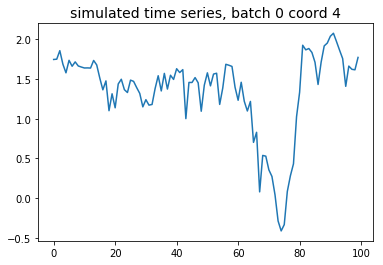

In [9]:
# plot simulated time series for one coordinate
coord_ind = 4
batch_ind = 0
plt.plot(sim_data.detach().numpy()[batch_ind, coord_ind,:]);
plt.title('simulated time series, batch %i coord %i' %(batch_ind, coord_ind), fontsize=14);

In [10]:
# use statistics.sample_from_prior to obtain simulated latens and observations
sim_lats , sim_observs = statistics.sample_from_prior(initial,
                                transition,
                                emission, 
                                num_timesteps,
                                batch_size)
print(sim_lats[-1].size()) # [batch_size, dim_latents]
print(sim_observs[-1].size()) # [batch_size, dim_obs]

torch.Size([10, 2])
torch.Size([10, 6])


In [12]:
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
lat_data.shape # [batch_size, dim_latents, num_timesteps]

torch.Size([10, 2, 100])

In [15]:
from aesmc import inference

inference_result = inference.infer(
            inference_algorithm='smc',
            observations=sim_observs, 
            initial=initial,
            transition=transition,
            emission=emission,
            proposal=proposal,
            num_particles=1000
        )

In [16]:
print(len(inference_result))

7


inference runs properly; now let's check if it is indeed making sense.

In [17]:
# ToDo: consider wrapping in a function e.g., summarize_posterior(latents, their weights)
smc_smoothed_state_means = []
smc_smoothed_state_variances = []
for latent in inference_result['latents']:
    smc_smoothed_state_means.append(statistics.empirical_mean(
        latent, inference_result['log_weight']
    ))
    smc_smoothed_state_variances.append(statistics.empirical_variance(
        latent, inference_result['log_weight']
    ))

In [18]:
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2) # now b, should be obs in observations
smooth_mean =  torch.cat([mean.unsqueeze(-1) for
                           mean in smc_smoothed_state_means], dim=2)
smooth_var = torch.cat([var.unsqueeze(-1) for
                           var in smc_smoothed_state_variances], dim=2)

In [19]:
smooth_mean.shape

torch.Size([10, 2, 100])

In [20]:
ind_in_batch = 4
dim_lat_plot = 0
np.max(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy()) # 0! it's also not on the same scale

0.0031602383

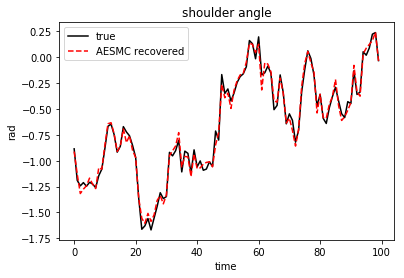

In [21]:
ind_in_batch = 5 # could be between 0 and batch_size-1
dim_lat_plot = 0
plt.plot(lat_data[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'black', label="true");
plt.plot(smooth_mean[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'red', 
         linestyle = 'dashed', label = "AESMC recovered");
#plt.plot(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'gray'); # 0! it's also not on the same scale
plt.title('shoulder angle')
plt.ylabel('rad')
plt.xlabel('time')
plt.legend();
#plt.savefig('first_fig_aesmc.png')

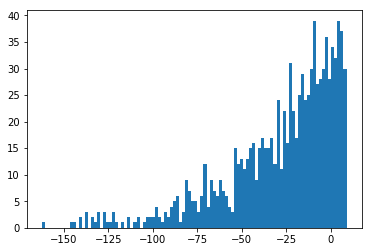

In [22]:
plt.hist(inference_result["log_weight"][0,:].detach().numpy(), bins=100);

In [23]:
# predicted coordinates
ind_in_batch = 8 # could be between 0 and batch_size-1
x_hat , y_hat = arm_utils.coords_from_params_mat(smooth_mean[ind_in_batch,0,:].detach().numpy(), 
                                       smooth_mean[ind_in_batch,1,:].detach().numpy(), L1_true, L2_true)

In [24]:
x_obs = sim_data[ind_in_batch, [0,2,4], :].detach().numpy().T
y_obs = sim_data[ind_in_batch, [1,3,5], :].detach().numpy().T

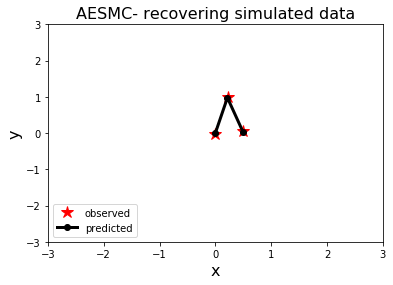

In [45]:
arm_utils.video_sim_plane_2D(x_obs, y_obs, x_hat, y_hat, 'FW-KIN-2D_plots/fw-kin-2d-recovered', 
                   "AESMC- recovering simulated data", x_hat.shape[0], L1_true + L2_true + 1)

In [25]:
# if we wanna train try that here
num_iterations = 600 # override previous statements. ToDo: define those here
L1_init =  0.7
L2_init = 1.3
training_stats = forward_kin_2D.TrainingStats(
                L1_true, L2_true, 
                num_timesteps,
                logging_interval)

train.train(dataloader=dataloader, # loads ground truth observations
            num_particles=num_particles,
            algorithm='aesmc',
            initial=initial, # the true distribution, assume we're not learning
            transition=transition, # same here
            emission= forward_kin_2D.Emission(forward_kin_2D.FW_kin_2D, 
                        L1_init, L2_init, emission_scale, True), # new trainable instance
            proposal=proposal,
            num_epochs=1,
            num_iterations_per_epoch=num_iterations,
            callback=training_stats)

Iteration 0: Loss = 2425.797607421875
0.42
Iteration 10: Loss = 2336.669921875
0.41
Iteration 20: Loss = 1874.929931640625
0.39
Iteration 30: Loss = 2499.093017578125
0.38
Iteration 40: Loss = 1473.1455078125
0.37
Iteration 50: Loss = 1874.2884521484375
0.35
Iteration 60: Loss = 1555.5086669921875
0.34
Iteration 70: Loss = 1519.94091796875
0.33
Iteration 80: Loss = 933.16845703125
0.31
Iteration 90: Loss = 1025.158447265625
0.3
Iteration 100: Loss = 1350.9305419921875
0.29
Iteration 110: Loss = 694.0690307617188
0.28
Iteration 120: Loss = 717.2086181640625
0.27
Iteration 130: Loss = 521.9531860351562
0.26
Iteration 140: Loss = 689.6055908203125
0.25
Iteration 150: Loss = 249.54574584960938
0.24
Iteration 160: Loss = 234.2554168701172
0.23
Iteration 170: Loss = 397.1158447265625
0.22
Iteration 180: Loss = 136.1350555419922
0.21
Iteration 190: Loss = 138.78709411621094
0.2
Iteration 200: Loss = 6.268255710601807
0.19
Iteration 210: Loss = 93.26509094238281
0.18
Iteration 220: Loss = -129

In [26]:
# convert static parameters as arrays for plotting
L1_in_train = np.asarray(training_stats.curr_L1)
L2_in_train = np.asarray(training_stats.curr_L2)

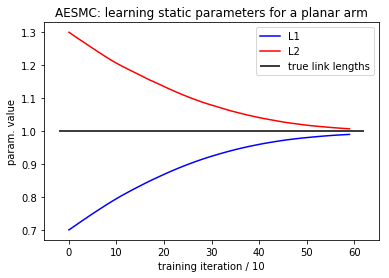

In [27]:
plt.hlines(xmin=-2, xmax=62, y=1, label = "true link lengths")
plt.plot(L1_in_train, label= "L1", color = 'blue')
plt.plot(L2_in_train, label="L2", color = 'red')
plt.xlabel("training iteration / 10")
plt.ylabel("param. value")
plt.title('AESMC: learning static parameters for a planar arm')
plt.legend();
plt.savefig('FW-KIN-2D_plots/fw-kin-2d-stat-param.png')

In [28]:
loss_in_training = np.asarray(training_stats.loss)

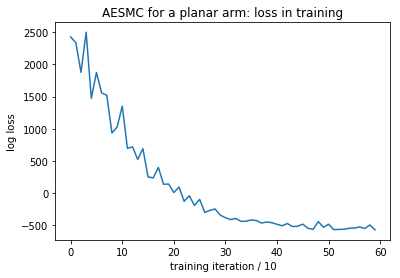

In [31]:
plt.plot(loss_in_training, label= "loss")
plt.xlabel("training iteration / 10")
plt.ylabel("log loss")
plt.title('AESMC for a planar arm: loss in training')
#plt.legend();
plt.savefig('FW-KIN-2D_plots/fw-kin-2d-loss.png')

## Miscellaneous 
Bunch of things I have played with, like changing dimensions of tensors and distribution objects.

In [32]:
import aesmc.state as state

In [33]:
# how to expand a scalar to dimensions of interest
a = torch.rand(10,2)
b = torch.tensor(1)
b.expand(a.shape).shape

torch.Size([10, 2])

In [35]:
# # # make up a list of inferred latents
# # the dim should be [batch_size, num_particles, dim_latents]
inferred_latents_list = []
for i in range(num_timesteps):
    inferred_latents_list.append(torch.rand([batch_size, num_particles, 2]))
print(len(inferred_latents_list))
print(inferred_latents_list[-1].shape)

100
torch.Size([10, 100, 2])


In [14]:
# # check how the output of the proposal looks like
# print(proposal(time=0, observations=observations)) # first call
# print(proposal(time=2, previous_latents= inferred_latents_list, observations=observations)) # second call
# # note that the inferred latents_list is longer than needed and not appropriate

In [36]:
# we would like to keep these dimesions, expand the observations to be 
# [batch_size, num_particles, dim_observations] and then concatanate 
print(observations[0].shape)
print(observations[0].view(-1, 1, 6).shape)
print(observations[0][0,:])
print(observations[0].view(-1, 1, 6)[0,0,:])
print(observations[0].view(-1, 1, 6).expand(10,num_particles,6).shape)
print("that is [batch_size, num_particles, dim_observations]")
print(observations[0].view(-1, 1, 6).expand(10,num_particles,6)[0,89,:]) # 0th batch, 89th particle, all obs dims
cat = torch.cat([inferred_latents_list[-1], 
           observations[0].view(-1, 1, 6).expand(10,num_particles,6)
                ], 
                dim=2)
print(cat.shape) # print out cat vals below
print("that is [batch_size, num_particles, dim_observations + dim_latents]")
print("now we have to push things through a linear layer")
print("so first view in two dimensions [batch_size*num_particles, dim_observations + dim_latents]")
print(cat.view(-1,8).shape)
print("push through FF layer")
activ = proposal_instance.lin_t(cat.view(-1,8))
print(activ.shape)
print("get [batch_size*num_particles, dim_latents], and reshape again to canonical form")
print(activ.view(batch_size,num_particles,2).shape)
prop_t_mu = activ.view(batch_size,num_particles,2)

torch.Size([10, 6])
torch.Size([10, 1, 6])
tensor([ 0.0133, -0.0323,  0.7073, -0.7605,  1.7456, -0.6420])
tensor([ 0.0133, -0.0323,  0.7073, -0.7605,  1.7456, -0.6420])
torch.Size([10, 100, 6])
that is [batch_size, num_particles, dim_observations]
tensor([ 0.0133, -0.0323,  0.7073, -0.7605,  1.7456, -0.6420])
torch.Size([10, 100, 8])
that is [batch_size, num_particles, dim_observations + dim_latents]
now we have to push things through a linear layer
so first view in two dimensions [batch_size*num_particles, dim_observations + dim_latents]
torch.Size([1000, 8])
push through FF layer


NameError: name 'proposal_instance' is not defined

In [37]:
distr_obj_t = state.set_batch_shape_mode(
                torch.distributions.Normal(
                    loc=prop_t_mu,
                    scale=proposal_scale_t),#torch.tensor(proposal_scale_t).expand(prop_t_mu.shape)),
                state.BatchShapeMode.FULLY_EXPANDED)
print(distr_obj_t)
#print(distr_obj_t.scale)
# same output obtained by expanding
# distr_obj_t = state.set_batch_shape_mode(
#                 torch.distributions.Normal(
#                     loc=prop_t_mu,
#                     scale=torch.tensor(proposal_scale_t).expand(prop_t_mu.shape)),
#                 state.BatchShapeMode.FULLY_EXPANDED)
# print(distr_obj_t.scale)

NameError: name 'prop_t_mu' is not defined

In [64]:
# we could also use state.expand_observation and its fine
# ToDo -- add state.compress to batch_expanded mode
expanded_obs = state.expand_observation(observations[0], num_particles)
print(expanded_obs.shape)
print(torch.max(observations[0].view(-1, 1, 6).expand(10,num_particles,6)-expanded_obs))

torch.Size([10, 100, 6])
tensor(0.)


In [93]:
lin_toy = torch.tensor([[0,0],[1,10]])
print(lin_toy)
print(lin_toy.shape)
# both units see just the second column of the input (for each batch). 
# the second unit scales the second column by ten

tensor([[ 0,  0],
        [ 1, 10]])
torch.Size([2, 2])


In [94]:
# want to have full batch size mode, and view it in different ways and see what happens
vec_tens = torch.tensor(np.arange(8))
print(vec_tens)
vec_tens_full_expanded = vec_tens.view(2,2,2)
print(vec_tens_full_expanded)
vec_tens_batch_expanded = vec_tens_full_expanded.view(4,2)
print(vec_tens_batch_expanded)
vec_tens_full_expanded_2 = vec_tens_batch_expanded.view(2,2,2)
print(vec_tens_full_expanded_2)
print(torch.max(vec_tens_full_expanded-vec_tens_full_expanded_2))

tensor([0, 1, 2, 3, 4, 5, 6, 7])
tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]])
tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7]])
tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]])
tensor(0)


In [97]:
print(vec_tens_batch_expanded.shape)
matmul_batch = torch.mm(vec_tens_batch_expanded,lin_toy)
print(matmul_batch)
print(matmul_batch.shape)
print(matmul_batch.view(2,2,2))
print(matmul_batch.view(2,2,2)[0,:,:])
print("compare to the zero-th batch in the input:" )
print(vec_tens_full_expanded[0,:,:])
print("and we see that the two output units do what we expect for that batch")

torch.Size([4, 2])
tensor([[ 1, 10],
        [ 3, 30],
        [ 5, 50],
        [ 7, 70]])
torch.Size([4, 2])
tensor([[[ 1, 10],
         [ 3, 30]],

        [[ 5, 50],
         [ 7, 70]]])
tensor([[ 1, 10],
        [ 3, 30]])
compare to the zero-th batch in the input:
tensor([[0, 1],
        [2, 3]])
and we see that the two output units do what we expect for that batch
